Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Fine-Tuning VISTA3D Model for Hugging Face Pipeline

This tutorial will illustrate how to fine-tune a VISTA3D model using the Decathlon spleen dataset and integrate it into an existing VISTA3D Hugging Face pipeline.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](../figures/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    LoadImage,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToNumpy,
)
from monai.apps import download_url
from monai.networks.nets import vista3d132
from monai.apps.vista3d.sampler import sample_prompt_pairs
from monai.apps.vista3d.transforms import Relabeld, VistaPostTransformd
from monai.metrics import DiceMetric, compute_dice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
from huggingface_hub import snapshot_download

print_config()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.5.0a0+872d972e41.nv24.08
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.20.0a0
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.17.0
pynrrd version: 1.0.0
clearml version: 1.16.5rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Download model checkpoint

In [5]:
resource = "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/model_zoo/model_vista3d.pt"
if not os.path.exists(os.path.join(root_dir, "model.pt")):
    download_url(url=resource, filepath=os.path.join(root_dir, "model.pt"))
if os.path.exists(os.path.join(root_dir, "model.pt")):
    print("model downloaded successfully!")

model downloaded successfully!


## Set MSD Spleen dataset path

In [6]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Define Dataset finetuning setting. Checkout the label mapping index in [label_dict](./label_dict.json)

In [8]:
# In this case, user need to map the index in the original dataset label into the global class mapping defined in label_dict.
# "1" represents spleen in original label, while "3" represents spleen as defined by label_dict. If the target organ is not
# found in label_dict, user can use any value smaller than 512 (recommend using < 255 since Relabeld transform use torch.unit8).
# Relabeld transform will map "1" to "3" in the groundtruth label. if "2" is liver in this dataset ("1" in label_dict, the mapping is [[1,3],[2,1]]
label_mappings = {"default": [[1, 3]]}
# label_set represents the class indexes after Relabeld that will be included during training. For finetuning, 0 can be included but not necessary.
label_set = [0, 3]

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [-1000, 1000] and scales to [0, 1].
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 1.5)` based on the affine matrix.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `Relabeld` map the values in label to the VISTA3D global index based on `label_mapping`.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [9]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 1.5), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=2,
            image_key="image",
            image_threshold=0,
        ),
        Relabeld(keys="label", label_mappings=label_mappings, dtype=torch.uint8),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 1.5), mode=("bilinear", "nearest")),
        Relabeld(keys="label", label_mappings=label_mappings, dtype=torch.uint8),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([239, 239, 150]), label shape: torch.Size([239, 239, 150])


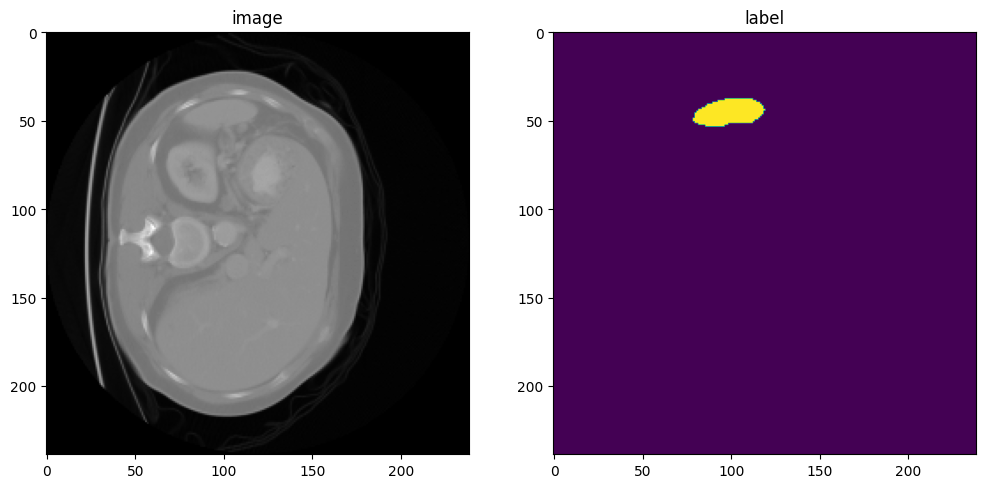

In [10]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 100], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 100])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [11]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=1 to load images and use RandCropByPosNegLabeld. only support batch size 1
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


## Create Model, Loss, Optimizer

In [12]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = vista3d132(encoder_embed_dim=48, in_channels=1).to(device)
model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt")))
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Define VISTA3D Training Configurations

In [13]:
# In this setting, we only finetune automatic training.
# maximum sampled points in each iteration
max_point = 5
# maximum sampled class prompt in each iteration
max_prompt = 32
# maximum sampled background class in each iteration
max_backprompt = 4
# maximum sampled foreground class in each iteration. None means use all.
max_foreprompt = None
# randomly remove class prompt
drop_label_prob = 0.2
# randomly remove points
drop_point_prob = 0.2

## Execute a typical PyTorch training process

In [ ]:
max_epochs = 5
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs_all, labels_all = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        loss_batch = 0.0
        for i in range(labels_all.shape[0]):
            # Current vista training only support batch size 1.
            inputs = inputs_all[[i]]
            labels = labels_all[[i]]
            label_prompt, point, point_label, prompt_class = sample_prompt_pairs(
                labels,
                label_set,
                max_point=max_point,
                max_prompt=max_prompt,
                max_backprompt=max_backprompt,
                max_foreprompt=max_foreprompt,
                drop_label_prob=drop_label_prob,
                drop_point_prob=drop_point_prob,
            )
            if prompt_class is None:
                continue
            optimizer.zero_grad()
            outputs = model(
                input_images=inputs, point_coords=point, point_labels=point_label, class_vector=label_prompt
            )
            loss, loss_n = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device)
            for id in range(len(prompt_class)):
                loss += loss_function(outputs[[id]].float(), labels == prompt_class[id])
                loss_n += 1.0
            loss /= max(loss_n, 1.0)
            loss.backward()
            optimizer.step()
            loss_batch += loss.item()
        epoch_loss += loss_batch / labels_all.shape[0]
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss_batch/labels_all.shape[0]:.4f}"
        )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_metric = []
        roi_size = (96, 96, 96)
        sw_batch_size = 1
        with torch.no_grad():
            for val_data in val_loader:
                val_outputs = sliding_window_inference(
                    val_data["image"].to(device),
                    roi_size,
                    sw_batch_size,
                    model,
                    transpose=True,
                    class_vector=torch.tensor(label_set[1:], device=device),
                )
                # VistaPostTransformd requires "0" to be excluded from label_prompt
                val_outputs = VistaPostTransformd(keys="pred")(
                    {"pred": val_outputs[0], "label_prompt": torch.tensor(label_set[1:], device=device)}
                )["pred"]
                _dice_metric = []
                # Must loop to calculate dice for incontinuous class indexes. 0 is excluded.
                for i in label_set[1:]:
                    _dice_metric.append(
                        compute_dice(
                            y_pred=val_outputs.unsqueeze(0) == i,
                            y=val_data["label"].to(device) == i,
                            include_background=False,
                        )
                    )
                dice_metric.append(_dice_metric)
            metric = torch.nanmean(torch.tensor(dice_metric))
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

In [15]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9524 at epoch: 1


## Plot the loss and metric

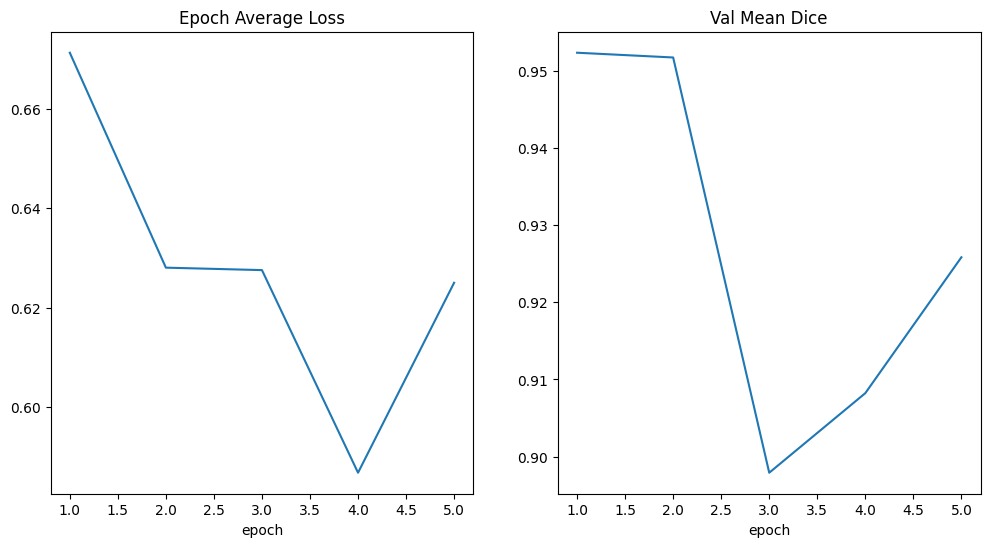

In [16]:
# this behavior is due to overfitting. VISTA3D has already been well trained on spleen09 dataset.
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 2
        # when performing inference, 0 should be excluded from label prompt.
        val_outputs = sliding_window_inference(
            val_data["image"].to(device),
            roi_size,
            sw_batch_size,
            model,
            transpose=True,
            class_vector=torch.tensor(label_set[1:], device=device),
        )
        val_outputs = VistaPostTransformd(keys="pred")(
            {"pred": val_outputs, "label_prompt": torch.tensor(label_set[1:], device=device)}
        )["pred"]
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(val_outputs.detach().cpu()[0, 0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Download the VISTA3D hugging face pipeine

In [ ]:
VISTA3D_HF_REPO = "MONAI/VISTA3D-HF"
snapshot_download(VISTA3D_HF_REPO, local_dir=".")

## Inference on the test set with the hugging face pipeline

In [ ]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
test_data = [{"image": image, "label_prompt": [3]} for image in test_images]

from vista3d_config import VISTA3DConfig
from vista3d_model import VISTA3DModel
from vista3d_pipeline import VISTA3DPipeline

config = VISTA3DConfig()
vista3d_hf_model = VISTA3DModel(config)
vista3d_hf_model.network.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# Save model to hugging face format so that it can be loaded by the from_pretrained API
hugging_face_model_path = os.path.join(root_dir, "huggging_face")
os.makedirs(hugging_face_model_path, exist_ok=True)
vista3d_hf_model.save_pretrained(hugging_face_model_path)
vista3d_hf_pipeline = VISTA3DPipeline(vista3d_hf_model, device=torch.device("cuda"))

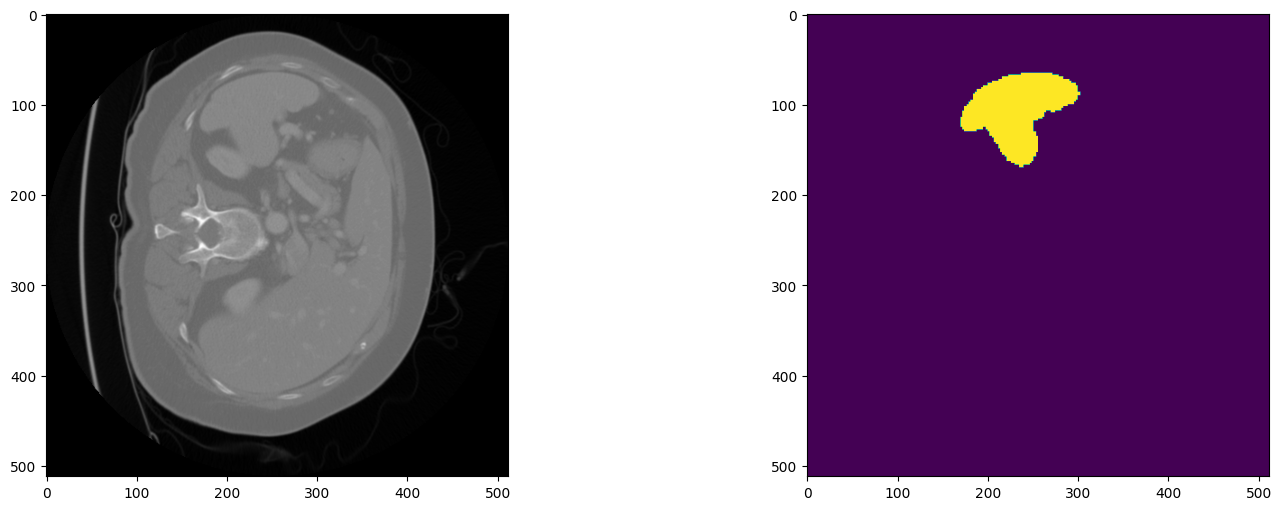

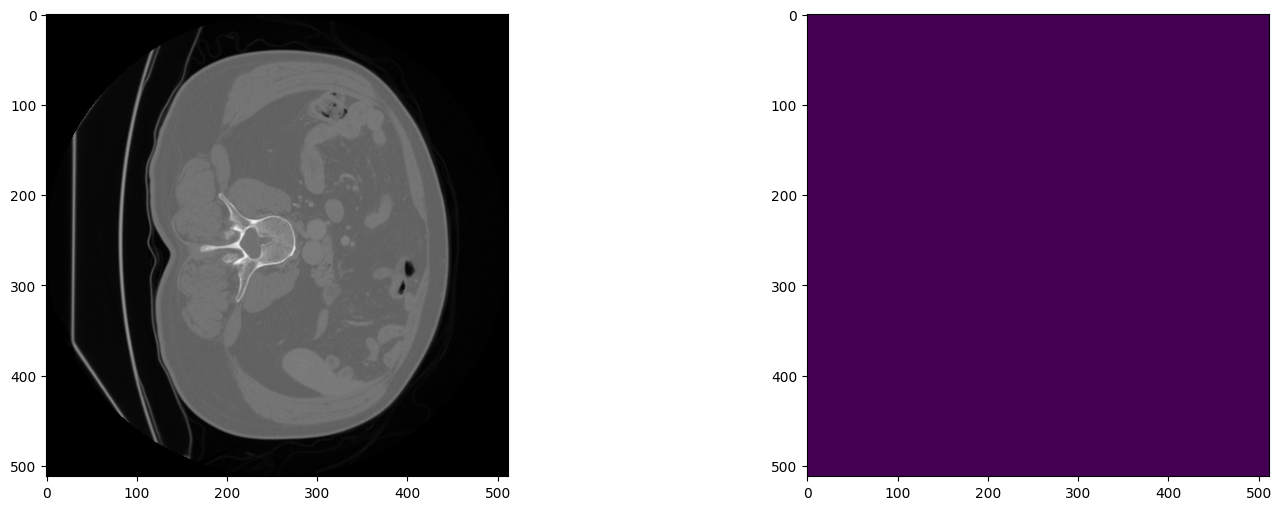

In [20]:
# Visualize the results.
numpy_transform = ToNumpy()
loader = LoadImage()

def convert_to_numpy(input):
    numpy_output = numpy_transform(input)
    numpy_output = np.squeeze(numpy_output, axis=0)
    return numpy_output


test_data = test_data[:2]
with torch.no_grad():
    test_outputs = vista3d_hf_pipeline(test_data, save_output=False)
    for test_output in test_outputs:
        original_image = loader(test_output[0]["image"].meta["filename_or_obj"])
        pred_output = convert_to_numpy(test_output[0]["pred"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(pred_output[:, :, 20])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [21]:
if directory is None:
    shutil.rmtree(root_dir)